# Imports & setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import json
import glob

# For statistical analysis and regression
from scipy.stats import linregress, t

# For matplotlib patches and lines (used in legends)
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# For matplotlib gridspec (used in some plotting functions)
import matplotlib.gridspec as gridspec

In [3]:
MODEL_COLOR_MAP = {
    "CLIP": "#1f77b4",
    "CLIP + ITM": "#ff7f0e",
    "CLIP + SimCLR": "#2ca02c",
    "CLIP + MLM": "#d62728",
    "CLIP + SimCLR + ITM": "#9467bd",
    "CLIP + ITM + MLM": "#8c564b",
    "CLIP + SimCLR + MLM": "#e377c2",
    "CLIP + ITM + SimCLR + MLM": "#7f7f7f",
    "SimCLR": "#bcbd22",
    "SimCLR + MLM": "#17becf",
    "SimCLR + ITM": "#aec7e8",
    "SimCLR + ITM + MLM": "#ffbb78",
    "ITM + MLM": "#98df8a",
}

# Functions

In [22]:
def make_accuracy_table_from_df(
    df,
    metric,
    dataset_fraction,
    method_notes,
    dataset_subsets,
    subset_names,
    random_chance_dict=None,
    model_order=None,
    require_clip=False,
    exclude_models=None,
    datasets_to_display=None  # <-- NEW: list of datasets to display (optional)
):
    """
    Create a table of accuracies (in %) for each model (rows) and dataset (columns),
    including average columns for specified dataset subsets at the right,
    and a row with chance probabilities.

    Args:
        df (pd.DataFrame): DataFrame with results.
        dataset_subsets (list of list): Each list contains dataset names for a subset.
        subset_names (list of str): Names for each subset (used as new dataset column).
        random_chance_dict (dict): Dict mapping dataset names to chance probabilities.
        require_clip (bool): If True, only include models with 'CLIP' in their name.
        metric (str): Metric to filter for.
        dataset_fraction (str): Dataset fraction to filter for.
        method_notes (str): Method notes to filter for.
        model_order (list or None): Optional order for models (rows).
        exclude_models (list or None): Optional list of model names to exclude.
        datasets_to_display (list or None): Optional list of datasets to display (columns).

    Returns:
        pd.DataFrame: Pivot table with models as rows and datasets as columns, plus a 'Chance' row.
    """
    # Filter your results
    df_filtered = df[
        (df['metric'] == metric) &
        (df['dataset_fraction'] == dataset_fraction) &
        (df['method_notes'] == method_notes)
    ]
    if require_clip:
        df_filtered = df_filtered[df_filtered['model_name'].str.contains('CLIP', case=False, na=False)]

    # Exclude models if requested
    if exclude_models is not None:
        df_filtered = df_filtered[~df_filtered['model_name'].isin(exclude_models)]

    # Convert scores to percentages
    df_filtered = df_filtered.copy()
    df_filtered['score'] = df_filtered['score'] * 100

    # Add average columns for each subset
    avg_cols = {}
    for subset, subset_name in zip(dataset_subsets, subset_names):
        subset_df = df_filtered[df_filtered['dataset'].isin(subset)]
        grouped = subset_df.groupby('model_name')['score'].mean()
        avg_cols[subset_name] = grouped

    # Pivot to get models as rows, datasets as columns (including averages)
    table = df_filtered.pivot_table(
        index='model_name', columns='dataset', values='score', aggfunc='first'
    )

    # Add average columns to the right
    for subset_name in subset_names:
        table[subset_name] = avg_cols[subset_name]

    # Move average columns to the rightmost positions
    other_cols = [col for col in table.columns if col not in subset_names]
    new_columns = other_cols + subset_names

    # Filter columns if datasets_to_display is provided
    if datasets_to_display is not None:
        # Only keep columns in datasets_to_display (order preserved), plus subset_names at the end
        keep_cols = [col for col in datasets_to_display if col in other_cols] + subset_names
        table = table.reindex(columns=keep_cols)
    else:
        table = table.reindex(columns=new_columns)

    # Reorder rows if model_order is provided
    if model_order is not None:
        # Only keep models present in the table
        model_order_filtered = [m for m in model_order if m in table.index]
        other_models = [m for m in table.index if m not in model_order_filtered]
        new_index = model_order_filtered + other_models
        table = table.reindex(new_index)

    # Add chance row (in percent)
    if random_chance_dict is not None:
        chance_row = []
        for col in table.columns:
            if col in random_chance_dict:
                chance_row.append(100 * random_chance_dict[col])
            elif col in subset_names:
                # For average columns, show mean chance of the subset if possible
                subset_idx = subset_names.index(col)
                subset = dataset_subsets[subset_idx]
                chances = [random_chance_dict[d] for d in subset if d in random_chance_dict]
                chance_row.append(100 * sum(chances) / len(chances) if chances else None)
            else:
                chance_row.append(None)
        table.loc['Chance'] = chance_row
    
    return table

In [33]:
def compute_delta_to_clip_table(table, baseline_model="CLIP", exclude_models=None):
    """
    Given a DataFrame with models as rows and datasets as columns (values = accuracy),
    compute the difference (delta) from each model to the CLIP baseline for each dataset.

    Args:
        table (pd.DataFrame): index=models, columns=datasets, values=accuracies.
        baseline_model (str): Name of the baseline model (default: "CLIP").
        exclude_models (list or None): Optional list of model names to exclude.

    Returns:
        pd.DataFrame: Same shape as input, with each value = model - CLIP for that dataset.
                      The baseline_model row will be all zeros.
    """
    # Optionally exclude models
    if exclude_models is not None:
        table = table[~table.index.isin(exclude_models)]

    # Ensure baseline exists
    if baseline_model not in table.index:
        raise ValueError(f"Baseline model '{baseline_model}' not found in table index.")

    # Subtract baseline row from all rows (broadcasting over columns)
    delta_table = table.subtract(table.loc[baseline_model], axis=1)
    return delta_table

In [27]:
def plot_model_deltas(
    df,
    datasets,
    figsize=(6, 4),
    show_values=True,
    model_order=None,
    exclude_models=None
):
    """
    Plot delta-accuracy to CLIP for one or more datasets.

    Parameters:
    - df: DataFrame with model names as index and datasets as columns.
    - datasets: str or list of dataset names (must be in df.columns).
    - figsize: Size of each subplot.
    - show_values: Show values next to bars.
    - model_order: Optional list specifying order of models (rows).
    - exclude_models: Optional list of model names to exclude.
    """
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.set(style="white")

    # Ensure datasets is a list
    if isinstance(datasets, str):
        datasets = [datasets]

    # Optionally exclude models
    plot_df = df.copy()
    if exclude_models is not None:
        plot_df = plot_df[~plot_df.index.isin(exclude_models)]

    # Optionally reorder models
    if model_order is not None:
        model_order_filtered = [m for m in model_order if m in plot_df.index]
        other_models = [m for m in plot_df.index if m not in model_order_filtered]
        new_index = model_order_filtered + other_models
        plot_df = plot_df.reindex(new_index)

    num_plots = len(datasets)
    fig, axes = plt.subplots(1, num_plots, figsize=(figsize[0] * num_plots, figsize[1]), sharex=False)
    fig.suptitle("Delta-Accuracy to CLIP baseline", fontsize=16, fontweight='bold')

    if num_plots == 1:
        axes = [axes]

    for ax, dataset_name in zip(axes, datasets):
        if dataset_name not in plot_df.columns:
            ax.set_visible(False)
            print(f"⚠️ Dataset '{dataset_name}' not found in DataFrame columns.")
            continue

        # Compute delta to CLIP
        if "CLIP" not in plot_df.index:
            ax.set_visible(False)
            print("⚠️ 'CLIP' baseline not found in DataFrame index.")
            continue

        baseline = plot_df.loc["CLIP", dataset_name]
        delta = plot_df[dataset_name] - baseline
        delta = delta.drop("CLIP", errors="ignore")
        delta = delta.sort_values(ascending=False)

        clean_labels = [name.replace("CLIP ", "").replace(" ", "") for name in delta.index]

        min_val, max_val = delta.min(), delta.max()
        range_padding = (max_val - min_val) * 0.30 if max_val != min_val else 1
        x_min = min_val - range_padding
        x_max = max_val + range_padding
        ax.set_xlim(x_min, x_max)

        sns.barplot(x=delta.values, y=clean_labels, ax=ax, palette="coolwarm", orient='h', hue=clean_labels, legend=False)

        ax.set_title(dataset_name, fontsize=14, fontweight='bold')
        ax.set_xlabel("Δ Accuracy in %", fontsize=12, fontweight='bold')
        ax.set_ylabel("")
        ax.axvline(0, color='black', linestyle='--', linewidth=1)

        for label in ax.get_yticklabels():
            label.set_fontsize(11)
            label.set_fontweight('bold')

        if show_values:
            for i, val in enumerate(delta.values):
                ha = 'left' if val >= 0 else 'right'
                offset = 0.005 * (x_max - x_min)
                x_pos = val + offset if val >= 0 else val - offset
                ax.text(x_pos, i, f"{val:.3f}", va='center', ha=ha, fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Zero-shot classification

In [ ]:
csv_path = r"..\..\test_results\model_scores_zero-shot.csv"
random_chance_dict = {
    "ImageNet": 1/1000.,
    'Caltech101':1/101.,
    'Caltech256':1/256.,
    'CIFAR10':1/10.,
    'CIFAR100':1/100.,
    'DTD':1/47.,
    'OxfordIIITPet':1./37 ,
    'StanfordCars': 1./196,
    'FGVCAircraft' : 1./102,
    'Food101': 1./101,
    'STL10': 1./10,
    'Places365': 1./365,
    # 'AllDatasetsAvg': 1/40,  # Average of all datasets
    # 'GeneralAvg': 1/26.69,  # Average of general datasets
    # 'FineGrainedAvg': 1/79.1  # Average of fine-grained datasets
}
dataset_order = ["ImageNet", "Caltech101", "Caltech256", "CIFAR10", "CIFAR100", "STL10",
    "Places365", "OxfordIIITPet", "Food101", "DTD", "StanfordCars", "FGVCAircraft"]
dataset_subsets = [
    ["ImageNet", "Caltech101", "Caltech256", "CIFAR10", "CIFAR100", "STL10", "Places365", "OxfordIIITPet", "Food101", "DTD", "StanfordCars", "FGVCAircraft"],
    ["ImageNet", "Caltech101", "Caltech256", "CIFAR10", "CIFAR100", "STL10"],
    ["Places365", "OxfordIIITPet", "Food101", "DTD", "StanfordCars", "FGVCAircraft"]
]
subset_names = ["AllDatasetsAvg", "GeneralAvg", "FineGrainedAvg"]
model_order = [
    "CLIP",
    "CLIP + ITM",
    "CLIP + SimCLR",
    "CLIP + MLM",
    "CLIP + SimCLR + ITM",
    "CLIP + ITM + MLM",
    "CLIP + SimCLR + MLM",
    "CLIP + ITM + SimCLR + MLM",
    "SimCLR",
    "SimCLR + MLM",
    "SimCLR + ITM",
    "SimCLR + ITM + MLM",
    "ITM + MLM",
]
templates_dict = {
    1: ["a photo of a {}."], 
    3: [
            "a photo of a {}.",
            "a photo of a small {}.",
            "a photo of a big {}."
        ],
    5: [
            "a photo of a {}.",
            "a photo of a small {}.",
            "a photo of a big {}.",
            "a bad photo of a {}.",
            "a good photo of a {}."
        ],
    9: [
            "a photo of a {}.",
            "a blurry photo of a {}.",
            "a black and white photo of a {}.",
            "a low contrast photo of a {}.",
            "a high contrast photo of a {}.",
            "a bad photo of a {}.",
            "a good photo of a {}.",
            "a photo of a small {}.",
            "a photo of a big {}."
        ],
    18: [
            "a photo of a {}.",
            "a blurry photo of a {}.",
            "a black and white photo of a {}.",
            "a low contrast photo of a {}.",
            "a high contrast photo of a {}.",
            "a bad photo of a {}.",
            "a good photo of a {}.",
            "a photo of a small {}.",
            "a photo of a big {}.",
            "a photo of the {}.",
            "a blurry photo of the {}.",
            "a black and white photo of the {}.",
            "a low contrast photo of the {}.",
            "a high contrast photo of the {}.",
            "a bad photo of the {}.",
            "a good photo of the {}.",
            "a photo of the small {}.",
            "a photo of the big {}."
        ]
}

df_zeroshot = load_df_with_dataset_averages(
    csv_path=csv_path,
    dataset_subsets=dataset_subsets,
    subset_names=subset_names,
    mode_col="mode"
)

## Delta to CLIP baseline

In [24]:
table = make_accuracy_table_from_df(
    df_zeroshot,
    metric='Top1Accuracy',
    dataset_fraction='1-aug',
    method_notes="0_templates",
    dataset_subsets=dataset_subsets, 
    subset_names=subset_names, 
    random_chance_dict=random_chance_dict, 
    require_clip=True
)
delta_table = compute_delta_to_clip_table(table)
display(delta_table)

dataset,CIFAR10,CIFAR100,Caltech101,Caltech256,DTD,FGVCAircraft,Food101,ImageNet,OxfordIIITPet,Places365,STL10,StanfordCars,AllDatasetsAvg,GeneralAvg,FineGrainedAvg
model_name,,,,,,,,,,,,,,,
CLIP,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CLIP + ITM,-1.356000,0.744000,0.561878,-0.563610,-1.063830,-0.179964,-0.617823,-0.119999,-2.472826,0.695892,2.620000,-0.024558,-0.148070,0.314378,-0.610518
CLIP + ITM + MLM,-0.294000,0.302000,0.000000,3.173372,-2.819148,-0.059988,-1.648845,1.150000,-0.760870,2.723289,-0.759995,0.294696,0.108376,0.595230,-0.378478
CLIP + ITM + SimCLR + MLM,-8.765998,2.283999,0.129664,0.939351,1.914895,-0.299940,0.314191,1.028000,-0.570653,1.945207,-5.379999,0.122790,-0.528208,-1.627497,0.571082
CLIP + MLM,-6.345999,-0.604001,3.155163,2.666938,2.500001,-0.419916,-0.532013,1.330000,-3.940218,3.364384,1.660001,0.036837,0.239265,0.310350,0.168179
CLIP + SimCLR,-3.185999,-1.430000,-6.814581,-3.410253,0.053191,-0.029994,0.025082,-0.294000,-1.983696,-0.465752,-3.959996,-0.049116,-1.795426,-3.182472,-0.408381
CLIP + SimCLR + ITM,-9.053999,-1.248001,0.605100,-2.385134,2.127659,0.239952,-1.242244,-0.826000,-1.630435,-0.717807,-2.480000,-0.036837,-1.387312,-2.564672,-0.209952
CLIP + SimCLR + MLM,-6.562001,0.658000,-0.835615,0.588116,1.382978,-0.269946,-0.166337,0.606000,-0.733696,2.383563,-2.139997,0.073674,-0.417938,-1.280916,0.445039
Chance,-42.010000,-18.980000,-42.461854,-33.368820,-12.500000,-0.219368,-14.063367,-14.942000,-7.677732,-16.230136,-71.559998,-0.312487,-22.860480,-37.220445,-8.500515


In [7]:
def make_model_vs_avg_table(
    df,
    metric="Top1Accuracy",
    dataset_fraction="1-aug",
    mode="regular",
    avg_names=("AllDatasetsAvg", "GeneralAvg", "FineGrainedAvg"),
    method_notes_list=None,  # e.g. ["1_templates", "9_templates", ...]
    model_col="model_name",
    dataset_col="dataset",
    method_notes_col="method_notes",
    score_col="score",
    require_clip=True,
    datasets_to_display=None
):
    """
    Returns a table with models as rows, columns as (avg_dataset, template_amount), values as accuracy.
    Only uses rows where dataset is in avg_names (unless datasets_to_display is set).
    If datasets_to_display is given, only those datasets are shown (order preserved).
    """
    # Filter
    df = df.copy()
    df = df[
        (df["metric"] == metric) &
        (df["dataset_fraction"] == dataset_fraction) &
        (df["mode"] == mode)
    ]
    # Optionally filter method_notes
    if method_notes_list is not None:
        df = df[df[method_notes_col].isin(method_notes_list)]
    # Optionally filter for CLIP models
    if require_clip is True:
        df = df[df[model_col].str.contains('CLIP', case=False, na=False)]
    elif require_clip is False:
        df = df[~df[model_col].str.contains('CLIP', case=False, na=False)]
    # Extract template amount as int
    df["template_amount"] = df[method_notes_col].str.extract(r"(\d+)").astype(float).astype("Int64")
    # Convert score to percent
    df[score_col] = (df[score_col] * 100).round(2)
    # Pivot
    table = df.pivot_table(
        index=model_col,
        columns=[dataset_col, "template_amount"],
        values=score_col,
        aggfunc="first"
    )
    table = table.sort_index(axis=1, level=[0,1])
    # Filter columns if datasets_to_display is given
    if datasets_to_display is not None:
        # Only keep columns where the first level (dataset) is in datasets_to_display, and preserve order
        keep_cols = []
        for d in datasets_to_display:
            for col in table.columns:
                if col[0] == d:
                    keep_cols.append(col)
        table = table[keep_cols]
    return table

table_zeroshot_templates = make_model_vs_avg_table(
    df_zeroshot, 
    metric="Top1Accuracy", 
    dataset_fraction="1-aug", 
    mode="regular",
    datasets_to_display=["CIFAR10"],
    # datasets_to_display=["FineGrainedAvg"],
    # datasets_to_display=["AllDatasetsAvg", "GeneralAvg", "FineGrainedAvg"],
)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(table_zeroshot_templates)

dataset                   CIFAR10                                   
template_amount                0      1      3      5      9      18
model_name                                                          
CLIP                        52.01  48.14  55.47  55.00  55.83  53.95
CLIP + ITM                  50.65  42.24  47.48  45.07  49.96  46.95
CLIP + ITM + MLM            51.72  58.13  57.34  58.32  59.02  58.28
CLIP + ITM + SimCLR + MLM   43.24  46.34  49.10  51.61  53.70  52.35
CLIP + MLM                  45.66  44.64  47.49  47.75  49.85  48.12
CLIP + SimCLR               48.82  41.96  40.39  41.84  37.18  37.60
CLIP + SimCLR + ITM         42.96  34.34  43.41  44.17  46.17  45.85
CLIP + SimCLR + MLM         45.45  44.33  46.87  47.72  50.39  48.47

In [36]:
def compute_delta_to_clip_multitemplate(table, baseline_model="CLIP"):
    """
    Given a DataFrame with models as rows and columns as (dataset, template_amount),
    compute the difference from each model to the CLIP baseline for each column.

    Args:
        table (pd.DataFrame): index=models, columns=MultiIndex (dataset, template_amount), values=accuracies.
        baseline_model (str): Name of the baseline model (default: "CLIP").

    Returns:
        pd.DataFrame: Same shape as input, with each value = model - CLIP for that (dataset, template_amount).
    """
    if baseline_model not in table.index:
        raise ValueError(f"Baseline model '{baseline_model}' not found in table index.")
    # Subtract the baseline row from all rows (broadcasting over columns)
    delta_table = table.subtract(table.loc[baseline_model], axis=1)
    delta_table = delta_table.drop(index=baseline_model)
    return delta_table

In [37]:
table_delta_zeroshot_templates = compute_delta_to_clip_multitemplate(table_zeroshot_templates)
table_delta_zeroshot_templates

dataset                   AllDatasetsAvg                                \
template_amount                       0     1     3     5     9     18   
model_name                                                               
CLIP + ITM                         -0.15 -0.63 -1.45 -1.58 -1.30 -1.51   
CLIP + ITM + MLM                    0.10  3.74  1.45  1.28  0.51  0.91   
CLIP + ITM + SimCLR + MLM          -0.53 -0.10 -1.97 -1.34 -1.11 -1.16   
CLIP + MLM                          0.24  1.71  0.07  0.06  0.25  0.53   
CLIP + SimCLR                      -1.80 -2.46 -3.18 -3.08 -3.55 -3.32   
CLIP + SimCLR + ITM                -1.39 -3.25 -4.24 -4.09 -3.79 -3.56   
CLIP + SimCLR + MLM                -0.42  0.94 -0.16 -0.17 -0.35 -0.02   

dataset                   CIFAR10                       ... STL10         \
template_amount                0      1      3      5   ...    3      5    
model_name                                              ...                
CLIP + ITM                  -1.36  -5.90  -7.99  -9.93  ... -4.45  -4.06   
CLIP + ITM + MLM            -0.29   9.99   1.87   3.32  ...  1.47   0.42   
CLIP + ITM + SimCLR + MLM   -8.77  -1.80  -6.37  -3.39  ... -5.07  -3.18   
CLIP + MLM                  -6.35  -3.50  -7.98  -7.25  ... -2.64  -2.56   
CLIP + SimCLR               -3.19  -6.18 -15.08 -13.16  ... -7.84  -6.54   
CLIP + SimCLR + ITM         -9.05 -13.80 -12.06 -10.83  ... -9.69 -10.04   
CLIP + SimCLR + MLM         -6.56  -3.81  -8.60  -7.28  ... -4.28  -4.32   

dataset                               StanfordCars                          \
template_amount              9     18           0     1     3     5     9    
model_name                                                                   
CLIP + ITM                -2.97 -2.71        -0.02 -0.03 -0.03  0.08 -0.04   
CLIP + ITM + MLM          -2.42 -2.54         0.30 -0.06  0.01  0.00 -0.12   
CLIP + ITM + SimCLR + MLM -3.34 -2.81         0.13 -0.19  0.03  0.17  0.06   
CLIP + MLM                -0.74 -0.20         0.04  0.03 -0.14 -0.08 -0.12   
CLIP + SimCLR             -5.10 -4.94        -0.05 -0.27  0.00  0.11  0.04   
CLIP + SimCLR + ITM       -8.54 -7.76        -0.03 -0.26  0.04  0.12 -0.05   
CLIP + SimCLR + MLM       -3.80 -2.72         0.08 -0.07  0.02 -0.09  0.02   

dataset                          
template_amount              18  
model_name                       
CLIP + ITM                 0.03  
CLIP + ITM + MLM           0.07  
CLIP + ITM + SimCLR + MLM  0.08  
CLIP + MLM                 0.05  
CLIP + SimCLR              0.19  
CLIP + SimCLR + ITM        0.06  
CLIP + SimCLR + MLM        0.03  

[7 rows x 90 columns]

In [47]:
def plot_accuracy_vs_templates_from_table(
    table,
    dataset,
    model_order=None,
    xlabel="Number of Templates",
    ylabel="Accuracy (%)",
    title=None,
    legend_loc="best"
):
    """
    Plots accuracy vs. number of templates for each model for a given dataset.
    
    Args:
        table (pd.DataFrame): MultiIndex columns (dataset, template_amount), rows=models.
        dataset (str): Dataset to plot (must be in table.columns.get_level_values(0)).
        model_order (list or None): Optional order for models (rows).
        xlabel (str): Label for x-axis.
        ylabel (str): Label for y-axis.
        title (str or None): Plot title.
        legend_loc (str): Legend location.
    """
    # Extract columns for the selected dataset
    cols = [col for col in table.columns if col[0] == dataset]
    if not cols:
        print(f"Dataset '{dataset}' not found in table columns.")
        return
    # Sort by template amount
    cols = sorted(cols, key=lambda x: x[1])
    template_amounts = [col[1] for col in cols]
    # Optionally reorder models
    models = list(table.index)
    if model_order is not None:
        models = [m for m in model_order if m in models] + [m for m in models if m not in model_order]
    # Plot
    plt.figure(figsize=(8, 5))
    for model in models:
        y = table.loc[model, cols].values
        color = MODEL_COLOR_MAP.get(model, "gray")  # Use color map here
        plt.plot(template_amounts, y, marker='o', label=model, color=color)
    # Add thick dashed line at y=0
    plt.axhline(0, color='black', linestyle='--', linewidth=1.25, zorder=0)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title or f"Accuracy vs. Number of Templates ({dataset})")
    plt.xticks(template_amounts)
    plt.legend(loc=legend_loc)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

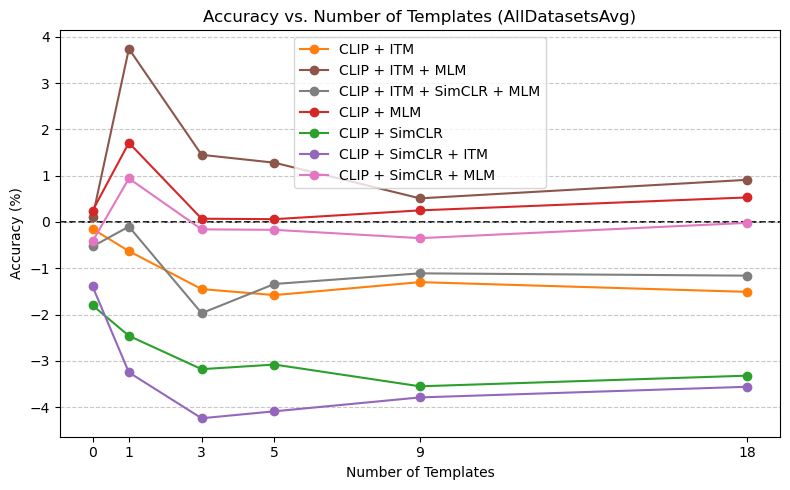

In [48]:
plot_accuracy_vs_templates_from_table(
    table_delta_zeroshot_templates,
    "AllDatasetsAvg",)

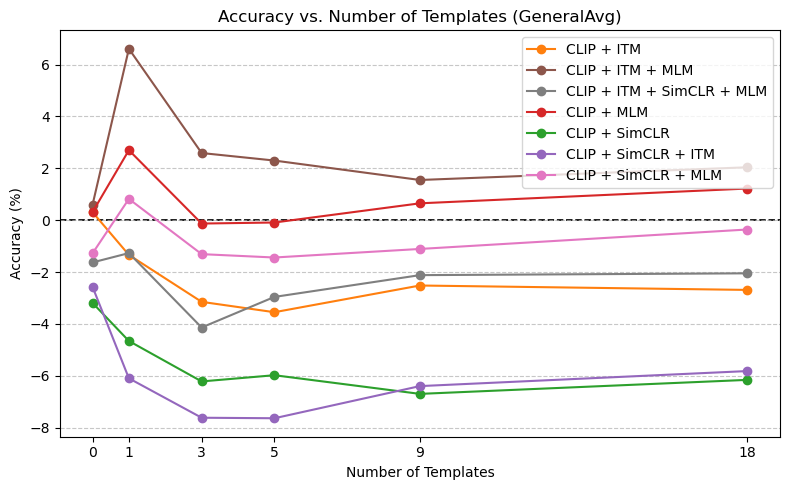

In [49]:
plot_accuracy_vs_templates_from_table(
    table_delta_zeroshot_templates,
    "GeneralAvg",)

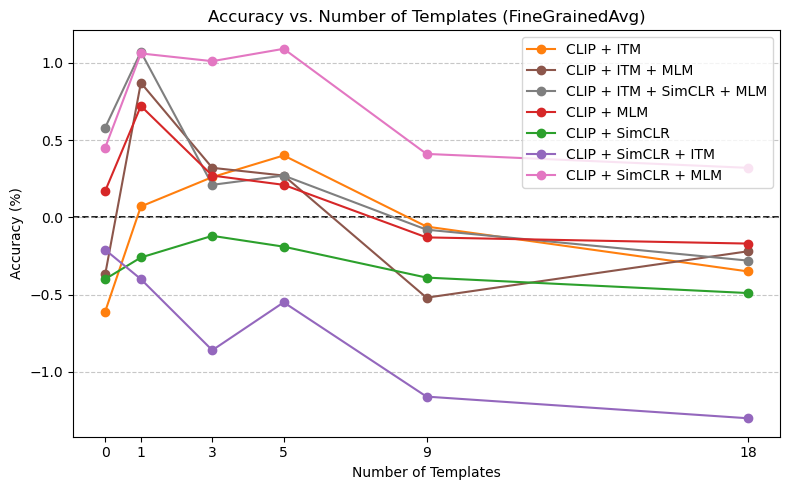

In [50]:
plot_accuracy_vs_templates_from_table(
    table_delta_zeroshot_templates,
    "FineGrainedAvg",)

# Linear probes

## Setup and load data

In [19]:
csv_path = "../../test_results/model_scores_linear_probe.csv"
random_chance_dict = {
    "ImageNet-100-0.1": 1/100.,
    "ImageNet-100-0.01": 1/100.,
    'Caltech101':1/101.,
    'Caltech256':1/256.,
    'CIFAR10':1/10.,
    'CIFAR100':1/100.,
    'DTD':1/47.,
    'OxfordIIITPet':1./37 ,
    'StanfordCars': 1./196,
    'FGVCAircraft' : 1./102,
    'Food101': 1./101,
    'STL10': 1./10,
    'Places365': 1./365,
    # 'AllDatasetsAvg': 1/40.67,  # Average of all datasets
    # 'GeneralAvg': 1/28.71,  # Average of general datasets
    # 'FineGrainedAvg': 1/79.1  # Average of fine-grained datasets
}
dataset_order = ["ImageNet-100-0.1", "ImageNet-100-0.01", "Caltech101", "Caltech256", "CIFAR10", "CIFAR100",
    "STL10", "Places365", "OxfordIIITPet", "Food101", "DTD", "StanfordCars", "FGVCAircraft"]
dataset_subsets = [
    ["ImageNet-100-0.1", "ImageNet-100-0.01", "Caltech101", "Caltech256", "CIFAR10", "CIFAR100", "STL10", "Places365", "OxfordIIITPet", "Food101", "DTD", "StanfordCars", "FGVCAircraft"],
    ["ImageNet-100-0.1", "ImageNet-100-0.01", "Caltech101", "Caltech256", "CIFAR10", "CIFAR100", "STL10"],
    ["Places365", "OxfordIIITPet", "Food101", "DTD", "StanfordCars", "FGVCAircraft"]
]
subset_names = ["AllDatasetsAvg", "GeneralAvg", "FineGrainedAvg"]
model_order = [
    "CLIP",
    "CLIP + ITM",
    "CLIP + SimCLR",
    "CLIP + SimCLR + ITM",
    "CLIP + MLM",
    "CLIP + ITM + MLM",
    "CLIP + SimCLR + MLM",
    "CLIP + ITM + SimCLR + MLM",
    "SimCLR",
    "SimCLR + MLM",
    "SimCLR + ITM",
    "SimCLR + ITM + MLM",
    "ITM + MLM",
]

dataset_subsets_dict = dict(zip(subset_names, dataset_subsets))

df_probe = load_df_with_dataset_averages(
    csv_path=csv_path,
    dataset_subsets=dataset_subsets,
    subset_names=subset_names,
    mode_col=None
)

## Plot table

In [30]:
table = make_accuracy_table_from_df(
    df_probe,
    metric='Top1Accuracy',
    dataset_fraction='1-aug',
    method_notes="last_image_layer",
    dataset_subsets=dataset_subsets, 
    subset_names=subset_names, 
    # random_chance_dict=random_chance_dict,
    model_order=model_order,
    exclude_models=["ITM + MLM", "SimCLR", "SimCLR + ITM"],
    datasets_to_display=["AllDatasetsAvg", "GeneralAvg", "FineGrainedAvg"]
)
table

dataset,AllDatasetsAvg,GeneralAvg,FineGrainedAvg
model_name,,,
CLIP,67.054645,78.941518,53.186627
CLIP + ITM,66.959628,78.951519,52.969090
CLIP + SimCLR,64.592130,76.654357,50.519531
CLIP + SimCLR + ITM,64.604153,76.891468,50.268952
CLIP + MLM,67.828707,79.898741,53.747000
CLIP + ITM + MLM,66.601733,78.760637,52.416345
CLIP + SimCLR + MLM,65.375125,77.903220,50.759014
CLIP + ITM + SimCLR + MLM,65.945042,78.485250,51.314798
SimCLR + MLM,46.754055,57.862867,33.793775


## Delta to CLIP

In [34]:
delta_table = compute_delta_to_clip_table(table, exclude_models=["SimCLR + MLM", "SimCLR + ITM + MLM"])
delta_table

dataset,AllDatasetsAvg,GeneralAvg,FineGrainedAvg
model_name,,,
CLIP,0.000000,0.000000,0.000000
CLIP + ITM,-0.095017,0.010001,-0.217537
CLIP + SimCLR,-2.462515,-2.287161,-2.667095
CLIP + SimCLR + ITM,-2.450492,-2.050050,-2.917675
CLIP + MLM,0.774062,0.957223,0.560374
CLIP + ITM + MLM,-0.452912,-0.180881,-0.770281
CLIP + SimCLR + MLM,-1.679520,-1.038298,-2.427612
CLIP + ITM + SimCLR + MLM,-1.109603,-0.456268,-1.871828


## Delta to CLIP plot

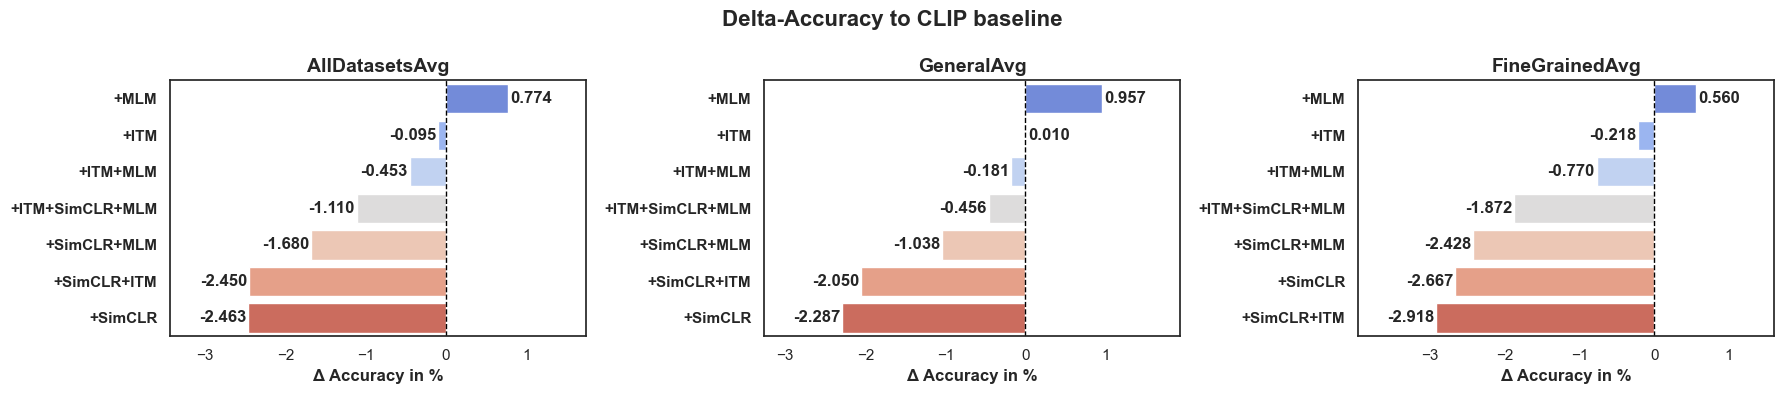

In [35]:
plot_model_deltas(delta_table, datasets=["AllDatasetsAvg", "GeneralAvg", "FineGrainedAvg"])

# Linear probes across layers

In [36]:
def plot_layerwise_accuracy(
    csv_path,
    dataset,
    metric="Top1Accuracy",
    subset_fraction="1-aug",
    models=None,  # list of model names to include, or None for all
    legend_loc="lower right",
    figsize=(10, 6),
    title=None,
    show_projection=True,
    color_palette="tab20",
    has_clip=None  # NEW: True = only CLIP, False = only non-CLIP, None = all
):
    """
    Plot accuracy over layers for each model.

    Args:
        csv_path (str): Path to the CSV file.
        dataset (str): Dataset to plot (default: "Caltech101").
        metric (str): Accuracy metric to plot (e.g., "Top1Accuracy").
        subset_fraction (str): Subset fraction to filter (e.g., "1-aug").
        models (list or None): List of model names to include. If None, plot all.
        legend_loc (str): Legend location.
        figsize (tuple): Figure size.
        title (str or None): Plot title. If None, generated automatically.
        show_projection (bool): If True, include "projection_layer" as last x-tick.
        color_palette (str or list): Matplotlib/seaborn color palette.
        has_clip (bool or None): If True, only models with 'CLIP' in name; if False, exclude those; if None, all.
    """
    df = pd.read_csv(csv_path)
    # Filter
    df = df[
        (df["dataset"] == dataset) &
        (df["metric"] == metric) &
        (df["subset_fraction"] == subset_fraction)
    ]
    if models is not None:
        df = df[df["model_name"].isin(models)]
    if has_clip is True:
        df = df[df["model_name"].str.contains("CLIP", case=False, na=False)]
    elif has_clip is False:
        df = df[~df["model_name"].str.contains("CLIP", case=False, na=False)]

    # Get all layers in order
    encoder_layers = sorted(
        [l for l in df["layer"].unique() if l.startswith("encoder_layer_")],
        key=lambda x: int(x.split("_")[-1])
    )
    if show_projection and "projection_layer" in df["layer"].unique():
        layers = encoder_layers + ["projection_layer"]
    else:
        layers = encoder_layers

    # Color mapping for models
    model_list = sorted(df["model_name"].unique())
    import seaborn as sns
    colors = sns.color_palette(color_palette, n_colors=len(model_list))
    color_map = dict(zip(model_list, colors))

    plt.figure(figsize=figsize)
    for model in model_list:
        sub = df[df["model_name"] == model]
        y = []
        for l in layers:
            row = sub[sub["layer"] == l]
            y.append(row["score"].values[0] if not row.empty else None)
        plt.plot(
            layers,
            y,
            marker="o",
            label=model,
            color=color_map[model]
        )
    plt.xlabel("Layer")
    plt.ylabel(metric)
    plt.xticks(
        range(len(layers)),
        [l.replace("encoder_layer_", "L") if l != "projection_layer" else "Proj" for l in layers],
        rotation=45
    )
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)
    plt.legend(loc=legend_loc, fontsize='small', ncol=3)
    if title is None:
        title = f"{metric} over Layers ({dataset}, {subset_fraction})"
    plt.title(title)
    plt.tight_layout()
    plt.show()

## Table

In [39]:
def get_layerwise_accuracy_table(
    df,
    dataset,
    metric="Top1Accuracy",
    subset_fraction="1-aug",
    dataset_fraction="1-aug",
    exclude_models=None,
    layers=None
):
    """
    Returns a table of linear probing accuracies for a dataset over all layers.
    Rows: models, Columns: layers.

    Args:
        df (pd.DataFrame): DataFrame with columns ['dataset', 'layer', 'metric', 'score', 'model_name', 'subset_fraction', 'dataset_fraction', ...].
        dataset (str): Dataset name to filter.
        metric (str): Metric to filter (default: "Top1Accuracy").
        subset_fraction (str): Subset fraction to filter (default: "1-aug").
        dataset_fraction (str): Dataset fraction to filter (default: "1-aug").
        exclude_models (list or None): Optional list of model names to exclude.
        layers (list or None): Optional list of layers to include and order columns.

    Returns:
        pd.DataFrame: Table with models as rows and layers as columns (values = accuracy in percent).
    """
    # Filter DataFrame
    df_filtered = df[
        (df["dataset"] == dataset) &
        (df["metric"] == metric) &
        (df["subset_fraction"] == subset_fraction) &
        (df["dataset_fraction"] == dataset_fraction)
    ].copy()

    if exclude_models is not None:
        df_filtered = df_filtered[~df_filtered["model_name"].isin(exclude_models)]

    # Convert score to percent
    df_filtered["score"] = df_filtered["score"] * 100

    # Pivot: rows=model_name, columns=layer, values=score
    table = df_filtered.pivot_table(
        index="model_name",
        columns="layer",
        values="score",
        aggfunc="first"
    )

    # Optionally order columns (layers)
    if layers is not None:
        table = table.reindex(columns=layers)
    else:
        # Default: sort encoder layers numerically, projection_layer last if present
        encoder_layers = sorted(
            [l for l in table.columns if l.startswith("encoder_layer_")],
            key=lambda x: int(x.split("_")[-1])
        )
        if "projection_layer" in table.columns:
            encoder_layers.append("projection_layer")
        table = table.reindex(columns=encoder_layers)

    return table

In [41]:
df_probe_layers = pd.read_csv("../../test_results/linear_probing_layers_results.csv")
table_layers = get_layerwise_accuracy_table(
    df_probe_layers,
    dataset="CIFAR10",
    metric="Top1Accuracy",
    subset_fraction="1-aug",
    dataset_fraction="1-aug",
    exclude_models=["ITM + MLM", "SimCLR", "SimCLR + ITM"],
)
table_layers

layer,encoder_layer_0,encoder_layer_1,encoder_layer_2,encoder_layer_3,encoder_layer_4,encoder_layer_5,encoder_layer_6,encoder_layer_7,encoder_layer_8,encoder_layer_9,encoder_layer_10,encoder_layer_11,projection_layer
model_name,,,,,,,,,,,,,
CLIP,40.290001,57.029998,62.750000,68.720001,73.150003,76.730001,80.610001,83.139998,85.329998,86.540002,86.820000,87.300003,83.130002
CLIP + ITM,40.790001,57.069999,62.540001,70.080000,73.949999,76.630002,80.170000,82.999998,85.589999,86.619997,86.919999,87.410003,82.849997
CLIP + ITM + MLM,41.639999,56.760001,62.930000,68.320000,72.970003,76.650000,79.780000,82.840002,85.339999,86.430001,86.460000,86.379999,81.569999
CLIP + ITM + SimCLR + MLM,39.129999,54.540002,59.829998,64.579999,69.720000,73.229998,77.999997,80.610001,83.420002,86.000001,86.790001,87.269998,83.480000
CLIP + MLM,39.919999,55.820000,63.090003,68.049997,73.079997,77.329999,81.389999,83.980000,86.570001,87.900001,88.220000,88.370001,82.770002
CLIP + SimCLR,38.980001,54.809999,59.640002,65.009999,70.840001,74.370003,77.480000,80.379999,82.800001,83.920002,84.930003,85.390002,81.760001
CLIP + SimCLR + ITM,39.070001,55.530000,59.979999,65.149999,70.300001,73.839998,77.319998,81.099999,82.590002,84.189999,85.579997,85.540003,81.580001
CLIP + SimCLR + MLM,40.180001,54.250002,58.950001,64.690000,70.010000,73.589998,76.959997,80.150002,82.630002,85.070002,86.320001,86.320001,83.050001
SimCLR + ITM + MLM,41.100001,53.520000,59.429997,63.340002,67.820001,72.000003,74.080002,75.770003,78.179997,78.950000,79.809999,79.659998,73.009998


## Plot

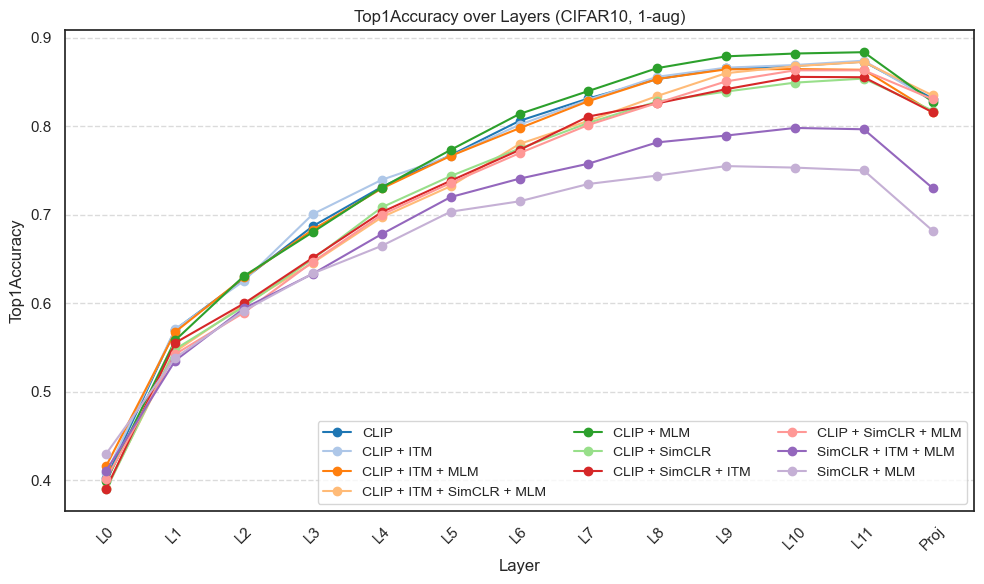

In [ ]:
plot_models = [x for x in model_order if not x in ["ITM + MLM", "SimCLR", "SimCLR + ITM"]]
plot_layerwise_accuracy(
    csv_path="../../test_results/linear_probing_layers_results.csv",
    dataset="CIFAR10",
    metric="Top1Accuracy",
    subset_fraction="1-aug",
    models=plot_models,
    has_clip=None  # set to True, False, or None as needed
)

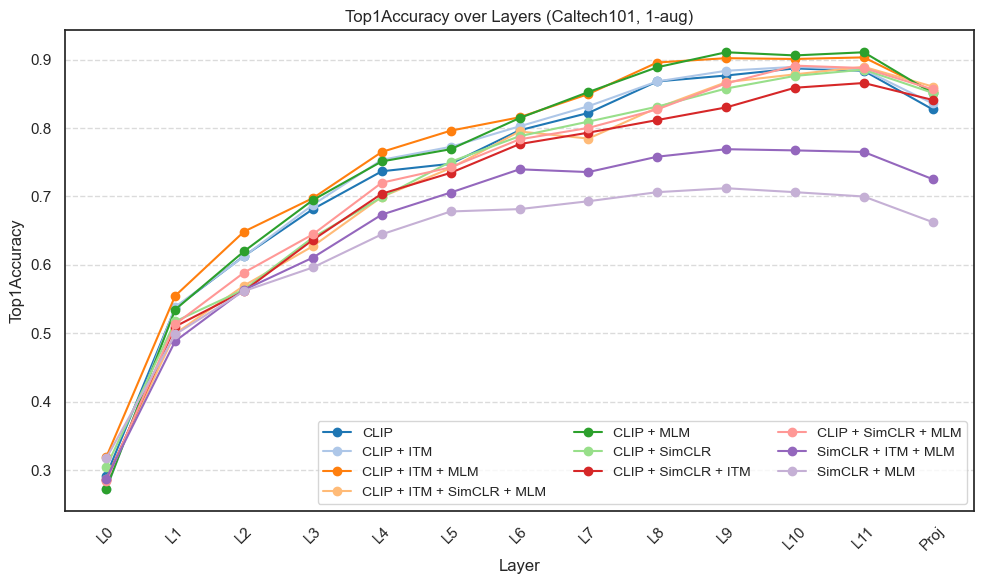

In [38]:
plot_models = [x for x in model_order if not x in ["ITM + MLM", "SimCLR", "SimCLR + ITM"]]
plot_layerwise_accuracy(
    csv_path="../../test_results/linear_probing_layers_results.csv",
    dataset="Caltech101",
    metric="Top1Accuracy",
    subset_fraction="1-aug",
    models=plot_models,
    has_clip=None  # set to True, False, or None as needed
)